In [1]:
from AL import *
from passive_model_perf import *
from update_combined_data import *
#from eval_adaptability import *
from compare_ATL_strategies import *
from analyze_target_tree_growth import *

import numpy as np
import joblib
import copy
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [31]:
source_id = joblib.load("./array_joblibs/final_source_id_dict.joblib")
source_desc = joblib.load("./array_joblibs/final_source_desc_dict.joblib")
source_y = joblib.load("./array_joblibs/final_source_y_dict.joblib")
target_id = joblib.load("./array_joblibs/final_target_id_dict.joblib")
target_desc = joblib.load("./array_joblibs/final_target_desc_dict.joblib")
target_y = joblib.load("./array_joblibs/final_target_y_dict.joblib")

In [8]:
DOMAINS = ["amides", "sulfonamides", "ROH", "anilines", "heterocycles", "alkyl amines"]
num_desired_rxns = [len(target_y[x])-sum(target_y[x]) for x in DOMAINS]
print(num_desired_rxns)

[5.0, 14.0, 17.0, 2.0, 8.0, 3.0]


In [24]:
[len(target_y[x]) for x in DOMAINS]

[40, 40, 48, 43, 43, 43]

In [9]:
### Preparing 25 source models of 5 trees of depth 1
all_source_models = []
for i, source in enumerate(DOMAINS):
    model_list = prepare_models(source_desc[source], source_y[source], 25)
    all_source_models.append(model_list)

In [50]:
def trellis_of_ATL_perfs(sources, targets):
    """ Prepares a 3x3 trellis plot of ATL performances compared to other baselines."""
    fig, ax = plt.subplots(3, 3, figsize=(12,10), gridspec_kw={"wspace":0.1, "hspace":0.1})

    for j, target in enumerate(targets):
        for i, source in enumerate(sources):
            if source != target : 
                ATL_perf, models = compare_ATL_strategies(
                    [source], [all_source_models[i]], [source_desc[source]], [source_y[source]],
                    target_desc[target], target_id[target], target_y[target]
                )
                scenario = f"{source}_to_{target}"
                sns.lineplot(
                    x="num_rxns_conducted", y="num_rxns_found",
                    hue="Strategy", style="Strategy", markers=True,
                    ci=95, palette="plasma", data=list(ATL_perf.values())[0], ax=ax[j,i]
                )

                if j < 2 :
                    ax[j,i].set_xticklabels([])
                    ax[j,i].set_xlabel('')
                    ax[j,i].get_legend().remove()
                else :
                    if i == 1 :
                        ax[j,i].set_xlabel(r"$\bf{"+'Number\ of\ Reactions\ Conducted'+"}$"+ f"\n\n{source}\n\n" +  r"$\bf{"+ 'Source\ Nucleophile'+ "}$",
                                           fontsize=12)
                        ax[j,i].get_legend().remove()
                    else : 
                        ax[j,i].set_xlabel("\n\n"+source, fontsize=12)
                        if i==0 :
                            ax[j,i].get_legend().remove()


                yticks = np.arange(len(target_y[target])-sum(target_y[target])+1, dtype=np.int8)
                ax[j,i].set_yticks(yticks)
                if i > 0 : 
                    ax[j,i].set_ylabel('')
                    ax[j,i].set_yticklabels([])
                else :
                    if j!= 1:
                        ax[j,i].set_ylabel(target+"\n\n", fontsize=12)
                    else :
                        ax[j,i].set_ylabel(r"$\bf{"+"Target\ Nucleophile"+"}$" + f"\n\n{target}\n\n" + r"$\bf{"+ "Number\ of\ Reactions\ Found" + "}$",
                                          fontsize=12)

                    ax[j,i].set_yticklabels(yticks)
                for axis in ['top', 'bottom', 'left', 'right']:
                    ax[j,i].spines[axis].set_linewidth(2)
                if sources == targets :
                    if j == 0 and i==1 :
                        ax[j,i].set_yticklabels(yticks)
                    elif j == 1 and i==2 :
                        xticks = list(ax[j,i].get_xticks())
                        xticks = [int(x) for x in xticks]
                        ax[j,i].set_xticklabels(xticks)
            
            else :
                if i == 0 :
                    ax[j,i].set_ylabel(target+"\n\n\n\n", fontsize=12)
                    # make x axis invisible
                    ax[j,i].xaxis.set_visible(False)
                    # makes the box invisible
                    plt.setp(ax[j,i].spines.values(), visible=False)
                    # remove ticks and labels for left axis
                    ax[j,i].tick_params(left=False, labelleft=False)
                
                if i == 1 :
                    ax[j,i].xaxis.set_visible(False)
                    ax[j,i].yaxis.set_visible(False)
                    plt.setp(ax[j,i].spines.values(), visible=False)
                    ax[j,i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
                elif i == 2 :
                    ax[j,i].set_xlabel("\n\n\n\n"+source, fontsize=12)
                    ax[j,i].yaxis.set_visible(False)
                    plt.setp(ax[j,i].spines.values(), visible=False)
                    # remove ticks and labels for bottom axis
                    ax[j,i].tick_params(bottom=False, labelbottom=False)
                

100%|██████████| 1/1 [00:09<00:00,  9.90s/it]


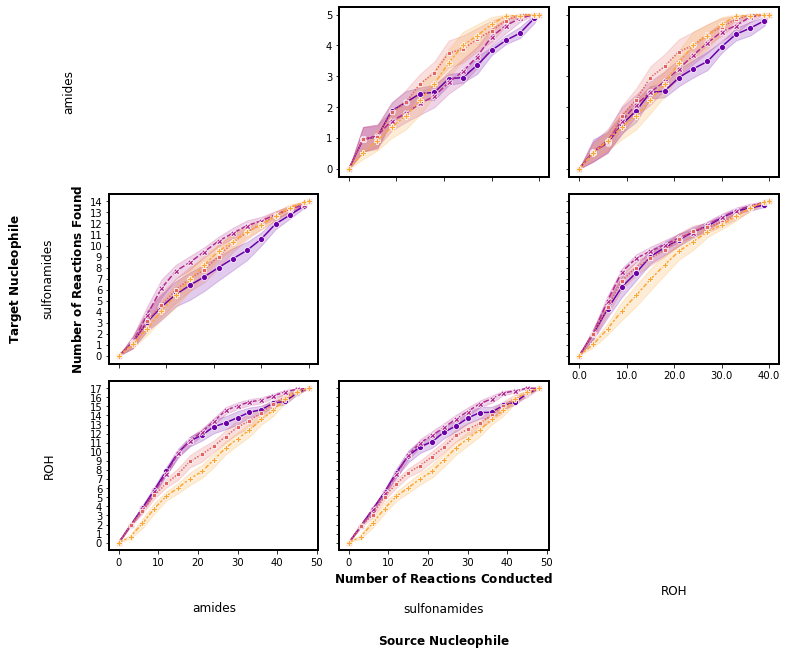

In [47]:
trellis_of_ATL_perfs(DOMAINS[:3], DOMAINS[:3])

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


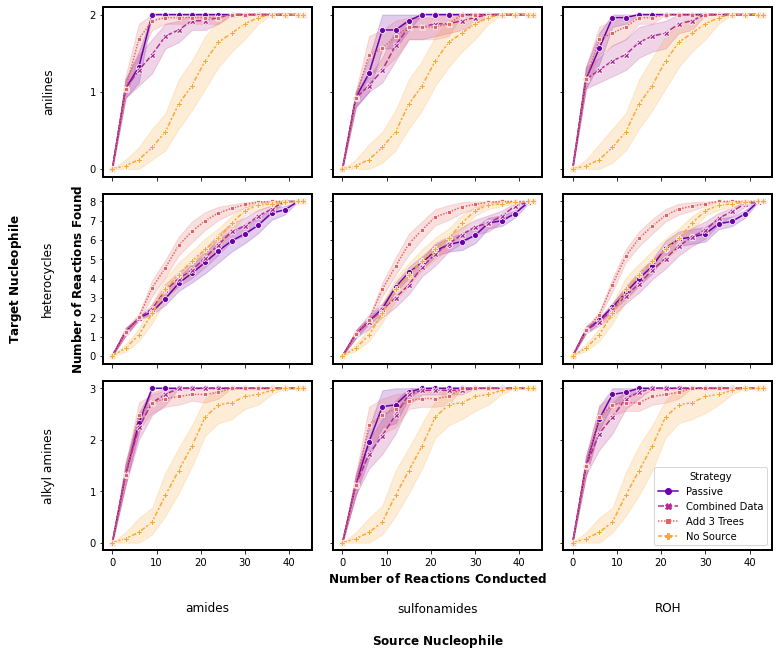

In [38]:
trellis_of_ATL_perfs(DOMAINS[:3], DOMAINS[3:])

100%|██████████| 1/1 [00:10<00:00, 10.16s/it]


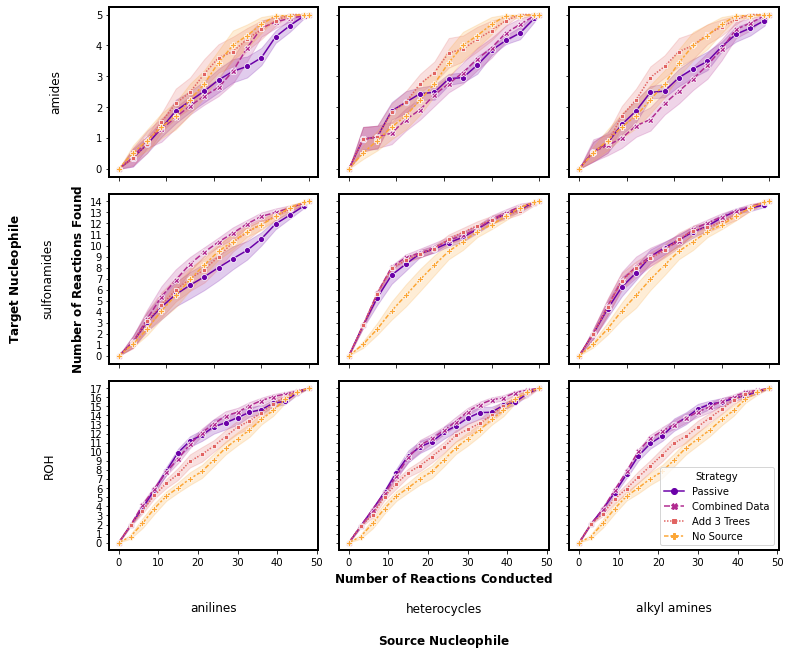

In [48]:
trellis_of_ATL_perfs(DOMAINS[3:], DOMAINS[:3])

100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


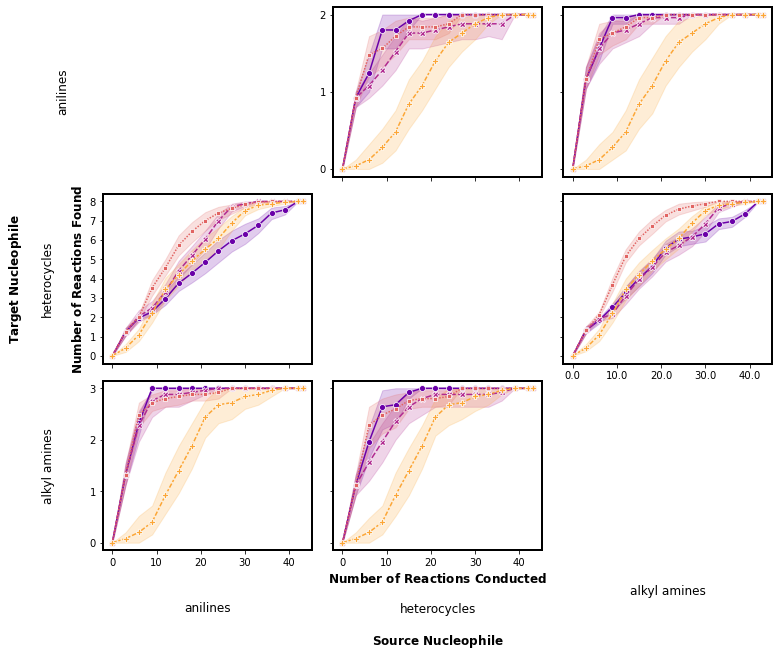

In [49]:
trellis_of_ATL_perfs(DOMAINS[3:], DOMAINS[3:])

In [19]:
list(ATL_perf.values())[0]

{'num_rxns_conducted': [0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  43,
  0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  